# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic
import DcOrient
import time

# Data Generation

In [28]:
G = misc.createRandomGraph(size=300, density=0.3, prioritized=False)
misc.graphInfo(G)

avg = misc.getAverageDegree(G)
variance = 0
degreeTuples = list(G.degree(list(G.nodes())))

for tuple in degreeTuples:
    variance += abs(avg - tuple[1])

variance = float(variance) / G.number_of_nodes()

variance

Nodes: 184
Edges: 5535
Density: 0.328759800427655
Max Degree: 78
Average Degree: 60.16304347826087
Static Coloring uses 21 colors


5.277055765595463

In [29]:
updates = misc.extractUpdates(G, 'shuffled')

In [30]:
Ge = nx.Graph()
Ge.add_nodes_from(list(G.nodes()))

# Algorithm Preparation

In [31]:
experimentList = []

experimentList.append((SmallBucket.SmallBucketAlgo(5, Ge), 'Small-Bucket algorithm with d = 5'))
experimentList.append((BigBucket.BigBucketAlgo(5, Ge), 'Big-Bucket algorithm with d = 5'))
experimentList.append((StaticDynamic.StaticDynamicAlgo(Ge, 50, dynamicReset=False), 'Static-Dynamic algorithm with l = 5'))
experimentList.append((RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 1 without max degree'))
experimentList.append((RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2 without max degree'))
experimentList.append((DcOrient.DcOrientAlgo(Ge), 'DC-Orient'))

# Experimenting

In [32]:
print('Graph used in the experiment:')
misc.graphInfo(G)

for experiment in experimentList:

    print("")
    print("------------------------------------------------------------------")
    print(str(experiment[1]) + ":")
    iterator = misc.UpdateIterator(experiment[0], updates)

    recolors = 0
    timer = time.perf_counter()

    while True:
        if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
            raise ValueError('The coloring produced is incorrect')
        c1 = iterator.algo.getColoring()
        if iterator.runUpdate(1):
            c2 = iterator.algo.getColoring()
            recolors += misc.numberOfRecolors(c1, c2)
        else:
            #print("all updates finished")
            break

    timer = time.perf_counter() - timer

    print("")
    print("Average number of recolors per update: " + str(float(recolors)/len(updates)))
    print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))
    print("Time taken : " + str(timer) + " seconds")
    print("------------------------------------------------------------------")

print("End of experiment list reached")



Graph used in the experiment:
Nodes: 184
Edges: 5535
Density: 0.328759800427655
Max Degree: 78
Average Degree: 60.16304347826087
Static Coloring uses 21 colors

------------------------------------------------------------------
Small-Bucket algorithm with d = 5:

Average number of recolors per update: 3.4896115627822946
Total number of colors used at the end: 45
Time taken : 7.210311000000019
------------------------------------------------------------------

------------------------------------------------------------------
Big-Bucket algorithm with d = 5:

Average number of recolors per update: 4.316531165311653
Total number of colors used at the end: 28
Time taken : 6.920796900000028
------------------------------------------------------------------

------------------------------------------------------------------
Static-Dynamic algorithm with l = 5:

Average number of recolors per update: 0.25420054200542
Total number of colors used at the end: 150
Time taken : 7.5098389999999995

# Results

In [ ]:
print("Average number of recolors per update: " + str(float(recolors)/len(updates)))
print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))

Average number of recolors per update: 2.6497695852534564
Total number of colors used at the end: 8


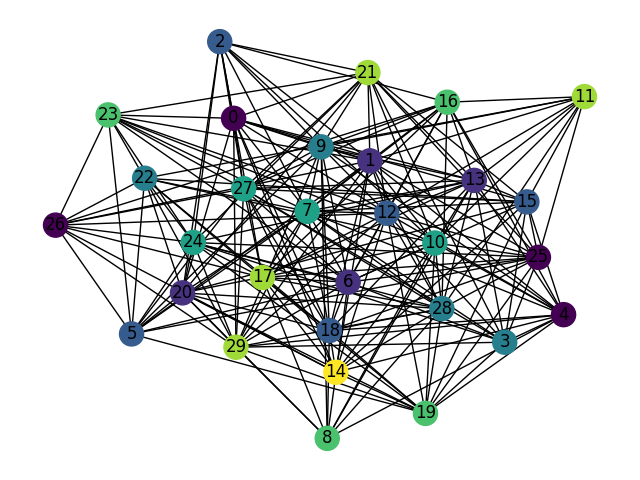

True


In [ ]:
misc.draw(iterator.algo.G, iterator.algo.getColoring())
print(misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()))